In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Installing FinRL
%%capture
!pip install wrds
!pip install swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [ ]:
!pip3 install tensorflow==2.9.1

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
import datetime
from gym.utils import seeding
from gym import spaces
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, TD3, SAC
from stable_baselines3.common.vec_env import DummyVecEnv
import sys
from sklearn.model_selection import ParameterGrid
from dateutil.relativedelta import relativedelta

## Preprocess Data

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [ ]:
# prediction length (months)
n_val = 6

In [ ]:
dataset = pd.read_csv("/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/rl_dataset.csv")
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [ ]:
# monthly price data
price_data = pd.read_csv("/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/price_data.csv", index_col='Date')
price_data.index = pd.to_datetime(price_data.index)
price_data = price_data.resample('ME').last()
price_data = price_data.sort_index()
price_long = price_data.reset_index().melt(id_vars=['Date'], var_name='Ticker', value_name='close')

In [ ]:
rl_df = dataset
rl_df.set_index('Date', inplace=True)
sorted_index = sorted(rl_df.index.unique())
# let's establish train, validation, and test periods here:
trainval_date_index = sorted_index[:-n_val]
test_date_index = sorted_index[-n_val:]
rl_df.reset_index(inplace=True)
rl_df.index = rl_df.Date.factorize()[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_prices = price_data[price_data.index.isin(trainval_date_index)]
train_prices = train_prices.sort_index()
test_prices = price_data[price_data.index.isin(test_date_index)]
test_prices = test_prices.sort_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# add covariance matrix as states
cov_list = []
return_list = []

# look back is one year
lookback=12
for i in range(lookback, len(rl_df.index.unique())):
    data_lookback = rl_df.loc[i-lookback:i,:]
    return_lookback = data_lookback.pivot_table(index = 'Date',columns = 'Ticker', values = 'ret')
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'Date':rl_df.Date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
rl_df = rl_df.merge(df_cov, on='Date')
rl_df = rl_df.sort_values(['Date','Ticker']).reset_index(drop=True)

In [ ]:
rl_df = price_long.merge(rl_df, on=['Date', 'Ticker']).drop('ret', axis=1)
rl_df = rl_df.sort_values(by=['Date', 'Ticker'])
# rl_df = rl_df.rename(columns={'Ticker': 'tic', 'Date': 'date'})
rl_df

,Date,Ticker,close,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,6 Mo,30 Yr,cov_list,return_list
0,2011-06-30,ABT,19.286484,0.024992,0.386255,0.875106,0.031333,0.204655,0.10,4.38,"[[0.0023056468821767186, 0.001835162978906446,...",Ticker ABT ADM ADP ...
151,2011-06-30,ADM,21.520960,0.007280,0.267717,2.193989,0.009030,0.016659,0.10,4.38,"[[0.0023056468821767186, 0.001835162978906446,...",Ticker ABT ADM ADP ...
302,2011-06-30,ADP,34.434196,0.010603,0.741108,0.491198,0.007088,0.096446,0.10,4.38,"[[0.0023056468821767186, 0.001835162978906446,...",Ticker ABT ADM ADP ...
453,2011-06-30,AFL,17.002453,0.015741,0.456204,-0.849405,0.002579,0.053852,0.10,4.38,"[[0.0023056468821767186, 0.001835162978906446,...",Ticker ABT ADM ADP ...
604,2011-06-30,ALB,57.806545,0.002848,0.131519,0.594561,0.034882,0.155066,0.10,4.38,"[[0.0023056468821767186, 0.001835162978906446,...",Ticker ABT ADM ADP ...
...,...,...,...,...,...,...,...,...,...,...,...,...
8606,2023-12-31,TGT,141.372864,0.007768,0.522142,1.687609,0.017269,0.038393,5.26,4.03,"[[0.0041682243668926125, 0.0021721257129901322...",Ticker ABT ADM ADP ...
8757,2023-12-31,TROW,106.554497,0.011745,0.639168,-0.227128,0.035639,0.266504,5.26,4.03,"[[0.0041682243668926125, 0.0021721257129901322...",Ticker ABT ADM ADP ...
8908,2023-12-31,WMT,52.371632,0.010905,3.395143,0.020519,0.001748,0.002817,5.26,4.03,"[[0.0041682243668926125, 0.0021721257129901322...",Ticker ABT ADM ADP ...
9059,2023-12-31,WST,351.742401,0.000572,0.108029,1.356211,0.035775,0.189331,5.26,4.03,"[[0.0041682243668926125, 0.0021721257129901322...",Ticker ABT ADM ADP ...


In [ ]:
# rl_train = rl_df.set_index('date')
rl_train = rl_df.set_index('Date')
rl_train = rl_train.loc[:trainval_date_index[-1], :]
rl_train = rl_train.reset_index()
# rl_train.index = rl_train.date.factorize()[0]
rl_train.index = rl_train.Date.factorize()[0]
rl_train

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Ticker,close,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,6 Mo,30 Yr,cov_list,return_list
0,2011-06-30,ABT,19.286484,0.024992,0.386255,0.875106,0.031333,0.204655,0.10,4.38,"[[0.0023056468821767186, 0.001835162978906446,...",Ticker ABT ADM ADP ...
0,2011-06-30,ADM,21.520960,0.007280,0.267717,2.193989,0.009030,0.016659,0.10,4.38,"[[0.0023056468821767186, 0.001835162978906446,...",Ticker ABT ADM ADP ...
0,2011-06-30,ADP,34.434196,0.010603,0.741108,0.491198,0.007088,0.096446,0.10,4.38,"[[0.0023056468821767186, 0.001835162978906446,...",Ticker ABT ADM ADP ...
0,2011-06-30,AFL,17.002453,0.015741,0.456204,-0.849405,0.002579,0.053852,0.10,4.38,"[[0.0023056468821767186, 0.001835162978906446,...",Ticker ABT ADM ADP ...
0,2011-06-30,ALB,57.806545,0.002848,0.131519,0.594561,0.034882,0.155066,0.10,4.38,"[[0.0023056468821767186, 0.001835162978906446,...",Ticker ABT ADM ADP ...
...,...,...,...,...,...,...,...,...,...,...,...,...
144,2023-06-30,TGT,128.486526,0.008381,0.523158,1.071126,0.018217,0.037736,5.47,3.85,"[[0.003941047796678278, 0.002496379764545381, ...",Ticker ABT ADM ADP ...
144,2023-06-30,TROW,108.303413,0.011529,0.588161,0.487107,0.037745,0.295864,5.47,3.85,"[[0.003941047796678278, 0.002496379764545381, ...",Ticker ABT ADM ADP ...
144,2023-06-30,WMT,51.838001,0.011013,0.919307,0.125159,0.006827,0.010985,5.47,3.85,"[[0.003941047796678278, 0.002496379764545381, ...",Ticker ABT ADM ADP ...
144,2023-06-30,WST,381.637482,0.000500,0.090909,0.863706,0.042266,0.207298,5.47,3.85,"[[0.003941047796678278, 0.002496379764545381, ...",Ticker ABT ADM ADP ...


In [ ]:
# rl_test = rl_df.set_index('date')
rl_test = rl_df.set_index('Date')
rl_test = rl_test.loc[test_date_index[0]:, :]
rl_test = rl_test.reset_index()
# rl_test.index = rl_test.date.factorize()[0]
rl_test.index = rl_test.Date.factorize()[0]

rl_test

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Ticker,close,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,6 Mo,30 Yr,cov_list,return_list
0,2023-07-31,ABT,109.641052,0.004664,0.647273,0.579201,0.018745,0.140335,5.53,4.02,"[[0.00349515557370727, 0.0017506040591579713, ...",Ticker ABT ADM ADP ...
0,2023-07-31,ADM,83.202370,0.005425,0.265372,1.332448,0.016703,0.036800,5.53,4.02,"[[0.00349515557370727, 0.0017506040591579713, ...",Ticker ABT ADM ADP ...
0,2023-07-31,ADP,243.141937,0.005165,0.666280,1.266638,0.015238,0.167461,5.53,4.02,"[[0.00349515557370727, 0.0017506040591579713, ...",Ticker ABT ADM ADP ...
0,2023-07-31,AFL,71.110138,0.005734,0.148715,4.164835,0.012509,0.315932,5.53,4.02,"[[0.00349515557370727, 0.0017506040591579713, ...",Ticker ABT ADM ADP ...
0,2023-07-31,ALB,210.543381,0.001904,0.072357,0.131976,0.034016,0.274258,5.53,4.02,"[[0.00349515557370727, 0.0017506040591579713, ...",Ticker ABT ADM ADP ...
...,...,...,...,...,...,...,...,...,...,...,...,...
5,2023-12-31,TGT,141.372864,0.007768,0.522142,1.687609,0.017269,0.038393,5.26,4.03,"[[0.0041682243668926125, 0.0021721257129901322...",Ticker ABT ADM ADP ...
5,2023-12-31,TROW,106.554497,0.011745,0.639168,-0.227128,0.035639,0.266504,5.26,4.03,"[[0.0041682243668926125, 0.0021721257129901322...",Ticker ABT ADM ADP ...
5,2023-12-31,WMT,52.371632,0.010905,3.395143,0.020519,0.001748,0.002817,5.26,4.03,"[[0.0041682243668926125, 0.0021721257129901322...",Ticker ABT ADM ADP ...
5,2023-12-31,WST,351.742401,0.000572,0.108029,1.356211,0.035775,0.189331,5.26,4.03,"[[0.0041682243668926125, 0.0021721257129901322...",Ticker ABT ADM ADP ...


## Build Environment

In [ ]:
class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step


    """
    metadata = {'render.modes': ['human']}

    def __init__(self,
                df,
                stock_dim,
                hmax, # max number of shares to trade
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                timestamp,
                agent_name,
                turbulence_threshold=None,
                lookback=12,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.agent_name = agent_name
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct = transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.timestamp = timestamp

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,))
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False
        self.turbulence_threshold = turbulence_threshold
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.Date.unique()[0]]


    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['monthly_return']
            plt.plot(df.monthly_return.cumsum(),'r')
            # plt.savefig(f"../data/RL/results/cumulative_reward_{self.timestamp}.png")
            plt.savefig(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/{timestamp}/{self.agent_name}/results/cumulative_reward.png')
            plt.close()

            plt.plot(self.portfolio_return_memory,'r')
            # plt.savefig(f"../data/RL/results/rewards_{self.timestamp}.png")
            plt.savefig(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/{timestamp}/{self.agent_name}/results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))
            print("end_total_asset:{}".format(self.portfolio_value))

            df_monthly_return = pd.DataFrame(self.portfolio_return_memory)
            df_monthly_return.columns = ['monthly_return']
            if df_monthly_return['monthly_return'].std() !=0:
              sharpe = (12**0.5)*df_monthly_return['monthly_return'].mean()/ \
                       df_monthly_return['monthly_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")

            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions)
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)

            # calculate portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.Date.unique()[0])
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.Date.unique()[0]]

        return self.state

    def render(self, mode='human'):
        return self.state

    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output


    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        df_account_value = pd.DataFrame({'date':date_list,'monthly_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['Date']

        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.Ticker.values
        df_actions.index = df_date.Date
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [ ]:
stock_dimension = len(rl_train.Ticker.unique())
state_space = stock_dimension

In [ ]:
initial_amount = 1000

In [ ]:
agents = ['a2c', 'ppo']

In [ ]:
root_dir = '/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/'

In [ ]:
for agent in agents:
  os.makedirs(os.path.join(root_dir, f'{timestamp}/{agent}/results/'), exist_ok=True)

In [ ]:
a2c_param_grid = {'gamma': [0.8, 0.99], 'ent_coef': [0.001, 0.005], 'gae_lambda': [0.75, 1.0]}
ppo_param_grid = {'gamma': [0.8, 0.99], 'ent_coef': [0.001, 0.005], 'gae_lambda': [0.75, 1.0]}

In [ ]:
#Calculate the Sharpe ratio
#This is our objective for tuning
def calculate_sharpe(df):
  if df['monthly_return'].std() !=0:
    sharpe = (12**0.5)*df['monthly_return'].mean()/ \
          df['monthly_return'].std()
    return sharpe
  else:
    return 0

In [ ]:
agent_best_params = {}

for agent_name in agents:
  print('#################')
  print('#################')
  print('#################')
  print(agent_name)
  print('#################')
  print('#################')
  print('#################')


  best_params = None
  best_score = -np.Inf
  best_idx = None

  for idx, params in enumerate(ParameterGrid(eval(f'{agent_name.lower()}_param_grid'))):
    env_kwargs = {
            "hmax": 100,
            "initial_amount": initial_amount,
            "transaction_cost_pct": 0.001,
            "state_space": state_space,
            "stock_dim": stock_dimension,
            "tech_indicator_list": rl_train.columns[3:-2],
            "action_space": stock_dimension,
            "reward_scaling": 1e-4,
            "timestamp": timestamp,
            "agent_name": agent_name
    }

    e_train_gym = StockPortfolioEnv(df = rl_train, **env_kwargs)

    env_train, _ = e_train_gym.get_sb_env()


    agent = DRLAgent(env = env_train)

    model = agent.get_model(model_name=agent_name, model_kwargs = params)

    trained_model = agent.train_model(model=model,
                                      tb_log_name=agent_name,
                                      total_timesteps=5000)

    trained_model.save(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/{timestamp}/{agent_name}/trained_{agent_name}_{idx}.pth')

    # make prediction on the test set to find Sharpe ratio
    e_trade_gym = StockPortfolioEnv(df = rl_test, **env_kwargs)

    df_monthly_return, df_actions = DRLAgent.DRL_prediction(model=trained_model, environment = e_trade_gym)

    df_monthly_return.to_csv(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/{timestamp}/{agent_name}/{agent_name}_rets_{idx}.csv')
    df_actions.to_csv(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/{timestamp}/{agent_name}/{agent_name}_wts_{idx}.csv')

    sharpe_ratio = calculate_sharpe(df_monthly_return)

    if sharpe_ratio > best_score:
      best_score = sharpe_ratio
      best_params = params
      best_idx = idx

  agent_best_params[agent_name] = [best_params, best_score, best_idx]

#################
#################
#################
a2c
#################
#################
#################
{'ent_coef': 0.001, 'gae_lambda': 0.75, 'gamma': 0.8}
Using cpu device


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4839.174353196973
Sharpe:  1.0191091479136036
begin_total_asset:1000
end_total_asset:4921.3097007677525
Sharpe:  1.0237237274256998
begin_total_asset:1000
end_total_asset:4784.351856328812
Sharpe:  1.0115813006015235
-------------------------------------
| time/                 |           |
|    fps                | 148       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -86.3     |
|    explained_variance | -8.34e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 3.14e+05  |
|    reward             | 2041.43   |
|    std                | 0.996     |
|    value_loss         | 1.33e+07  |
-------------------------------------
begin_total_asset:1000
end_total_asset:4826.851995765854
Sharpe:  1.0013006702768856
begin_total_asset:1000
end_total_asset:4680.8469937

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4871.7041988035935
Sharpe:  1.0127284019877687
begin_total_asset:1000
end_total_asset:4509.965661944956
Sharpe:  0.9844953285792458
begin_total_asset:1000
end_total_asset:4760.927015744928
Sharpe:  1.0228180071933524
-------------------------------------
| time/                 |           |
|    fps                | 119       |
|    iterations         | 100       |
|    time_elapsed       | 4         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -86.1     |
|    explained_variance | -4.77e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 3.5e+05   |
|    reward             | 2014.1864 |
|    std                | 0.992     |
|    value_loss         | 1.88e+07  |
-------------------------------------
begin_total_asset:1000
end_total_asset:4569.0765299872355
Sharpe:  0.9843262009484102
begin_total_asset:1000
end_total_asset:4993.864105

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4881.52780292811
Sharpe:  1.0202939055264366
begin_total_asset:1000
end_total_asset:5137.738049626105
Sharpe:  1.0389879537560747
begin_total_asset:1000
end_total_asset:4909.867653056828
Sharpe:  1.0234983164437823
-------------------------------------
| time/                 |           |
|    fps                | 126       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -85.9     |
|    explained_variance | -7.15e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 4.01e+05  |
|    reward             | 2074.0889 |
|    std                | 0.99      |
|    value_loss         | 2.33e+07  |
-------------------------------------
begin_total_asset:1000
end_total_asset:4817.7545024456795
Sharpe:  1.0036335711888407
begin_total_asset:1000
end_total_asset:5071.77244987

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4793.651606962474
Sharpe:  1.0240064777863418
begin_total_asset:1000
end_total_asset:4623.7600099344045
Sharpe:  0.9895771779991459
begin_total_asset:1000
end_total_asset:4858.450949911508
Sharpe:  1.0374714225061268
-------------------------------------
| time/                 |           |
|    fps                | 160       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -86.1     |
|    explained_variance | -4.77e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 5.15e+05  |
|    reward             | 2055.7412 |
|    std                | 0.993     |
|    value_loss         | 4.08e+07  |
-------------------------------------
begin_total_asset:1000
end_total_asset:4820.02891776361
Sharpe:  1.0157020374519816
begin_total_asset:1000
end_total_asset:4800.24033965

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4939.48895415159
Sharpe:  1.0237149118780855
begin_total_asset:1000
end_total_asset:4675.600103239611
Sharpe:  0.9904240687135911
begin_total_asset:1000
end_total_asset:4842.396157717589
Sharpe:  1.006558738533989
-------------------------------------
| time/                 |           |
|    fps                | 110       |
|    iterations         | 100       |
|    time_elapsed       | 4         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -86       |
|    explained_variance | -1.31e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 3.24e+05  |
|    reward             | 2110.655  |
|    std                | 0.991     |
|    value_loss         | 1.35e+07  |
-------------------------------------
begin_total_asset:1000
end_total_asset:4911.468395800452
Sharpe:  1.0179411798341245
begin_total_asset:1000
end_total_asset:4746.6078444183

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4881.282007307857
Sharpe:  1.0277564980121172
begin_total_asset:1000
end_total_asset:4698.870779187279
Sharpe:  0.9849022021341597
begin_total_asset:1000
end_total_asset:4667.297163856448
Sharpe:  0.9943503682140183
-------------------------------------
| time/                 |           |
|    fps                | 143       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -86.3     |
|    explained_variance | -9.54e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 3.69e+05  |
|    reward             | 2056.9792 |
|    std                | 0.996     |
|    value_loss         | 1.96e+07  |
-------------------------------------
begin_total_asset:1000
end_total_asset:4745.718344218863
Sharpe:  1.011551577135046
begin_total_asset:1000
end_total_asset:4687.679691925

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4750.36767161788
Sharpe:  1.0070604904064973
begin_total_asset:1000
end_total_asset:4696.048933734831
Sharpe:  0.9927354340541856
begin_total_asset:1000
end_total_asset:4845.182591310554
Sharpe:  1.0338244831234937
-------------------------------------
| time/                 |           |
|    fps                | 144       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -86.2     |
|    explained_variance | -7.15e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 4.05e+05  |
|    reward             | 2122.2253 |
|    std                | 0.994     |
|    value_loss         | 2.43e+07  |
-------------------------------------
begin_total_asset:1000
end_total_asset:5018.642015711078
Sharpe:  1.049552073036175
begin_total_asset:1000
end_total_asset:4690.4714780801

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4714.558405958209
Sharpe:  0.9960684207832219
begin_total_asset:1000
end_total_asset:4441.694406413039
Sharpe:  0.9745088397794298
begin_total_asset:1000
end_total_asset:4941.319554184693
Sharpe:  1.0207407036304228
-------------------------------------
| time/                 |           |
|    fps                | 114       |
|    iterations         | 100       |
|    time_elapsed       | 4         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -86.3     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 5.25e+05  |
|    reward             | 2101.2263 |
|    std                | 0.996     |
|    value_loss         | 4.3e+07   |
-------------------------------------
begin_total_asset:1000
end_total_asset:5035.326285408181
Sharpe:  1.0391176182011934
begin_total_asset:1000
end_total_asset:5050.99312395

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4943.613215633804
Sharpe:  1.0368984245215602
begin_total_asset:1000
end_total_asset:4913.528229508687
Sharpe:  1.0229532023915124
begin_total_asset:1000
end_total_asset:4674.213864559768
Sharpe:  0.9987062167708881
begin_total_asset:1000
end_total_asset:4981.606892330817
Sharpe:  1.0422467962070245
begin_total_asset:1000
end_total_asset:4966.893203309331
Sharpe:  1.0420116022784103
begin_total_asset:1000
end_total_asset:4756.20183861389
Sharpe:  1.0068856902623915
begin_total_asset:1000
end_total_asset:4342.094393600686
Sharpe:  0.9622239701527417
begin_total_asset:1000
end_total_asset:4943.510558254733
Sharpe:  1.0434067803657436
begin_total_asset:1000
end_total_asset:4747.9336667218995
Sharpe:  1.0104488782569816
begin_total_asset:1000
end_total_asset:4671.697052782277
Sharpe:  1.0020953918259712
begin_total_asset:1000
end_total_asset:4738.956956367207
Sharpe:  1.016476196825001
begin_total_asset:1000
end_total_asset:4883.327461227236
Sharpe:  

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4932.019091915732
Sharpe:  1.0217295830128188
begin_total_asset:1000
end_total_asset:4610.165160742149
Sharpe:  0.9878711587155755
begin_total_asset:1000
end_total_asset:4862.3001908603
Sharpe:  1.0246105025017511
begin_total_asset:1000
end_total_asset:4808.929213153126
Sharpe:  1.0020908723961974
begin_total_asset:1000
end_total_asset:4746.415430943651
Sharpe:  1.0035525455985128
begin_total_asset:1000
end_total_asset:4870.239903072393
Sharpe:  1.022925394336332
begin_total_asset:1000
end_total_asset:4965.397856268796
Sharpe:  1.0235527070502985
begin_total_asset:1000
end_total_asset:4805.544812787254
Sharpe:  1.0175653620715397
begin_total_asset:1000
end_total_asset:4798.918110205691
Sharpe:  1.010962596499043
begin_total_asset:1000
end_total_asset:4765.937039461473
Sharpe:  1.005754741209812
begin_total_asset:1000
end_total_asset:4827.185949237485
Sharpe:  1.0215288899629906
begin_total_asset:1000
end_total_asset:4761.749705344186
Sharpe:  1.01

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4509.527535334036
Sharpe:  0.9761184969145815
begin_total_asset:1000
end_total_asset:4936.64761721
Sharpe:  1.0294967721655017
begin_total_asset:1000
end_total_asset:4849.104701221274
Sharpe:  1.0253401448364627
begin_total_asset:1000
end_total_asset:4744.239291675523
Sharpe:  1.0053328706505404
begin_total_asset:1000
end_total_asset:5083.019196108099
Sharpe:  1.0460518551098092
begin_total_asset:1000
end_total_asset:4760.695888742185
Sharpe:  1.0035519116845772
begin_total_asset:1000
end_total_asset:4640.197646831567
Sharpe:  0.988980937600239
begin_total_asset:1000
end_total_asset:4777.367824507487
Sharpe:  1.0090063685589443
begin_total_asset:1000
end_total_asset:4734.074938231435
Sharpe:  1.0093614980587144
begin_total_asset:1000
end_total_asset:4743.318817566753
Sharpe:  1.013959202604749
begin_total_asset:1000
end_total_asset:4648.485918237413
Sharpe:  0.993608294363848
begin_total_asset:1000
end_total_asset:4686.194931566185
Sharpe:  0.9890

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4411.829978195996
Sharpe:  0.9549127788581885
begin_total_asset:1000
end_total_asset:4751.308413729986
Sharpe:  1.005242441406201
begin_total_asset:1000
end_total_asset:4645.609701300625
Sharpe:  0.9888860016285285
begin_total_asset:1000
end_total_asset:4641.08923306758
Sharpe:  0.998717122261821
begin_total_asset:1000
end_total_asset:4752.057664174042
Sharpe:  0.99751415189267
begin_total_asset:1000
end_total_asset:4973.543757274416
Sharpe:  1.032467382871866
begin_total_asset:1000
end_total_asset:4495.49814899233
Sharpe:  0.9727365780864508
begin_total_asset:1000
end_total_asset:4962.806644244635
Sharpe:  1.021923191311355
begin_total_asset:1000
end_total_asset:5087.031305543012
Sharpe:  1.0437721599690928
begin_total_asset:1000
end_total_asset:4884.336141291686
Sharpe:  1.0285492588463154
begin_total_asset:1000
end_total_asset:5063.609874531934
Sharpe:  1.0500317544966917
begin_total_asset:1000
end_total_asset:4651.108771541928
Sharpe:  0.99518

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4852.200412807347
Sharpe:  1.01768591744697
begin_total_asset:1000
end_total_asset:4706.932679359033
Sharpe:  1.0159970723085954
begin_total_asset:1000
end_total_asset:4594.339966839217
Sharpe:  0.9870989650864135
begin_total_asset:1000
end_total_asset:4608.377910165966
Sharpe:  0.9889367895780722
begin_total_asset:1000
end_total_asset:4803.343075882718
Sharpe:  1.0135268656543133
begin_total_asset:1000
end_total_asset:4491.688244589692
Sharpe:  0.9800406317819721
begin_total_asset:1000
end_total_asset:4534.693717262063
Sharpe:  0.9833283458347011
begin_total_asset:1000
end_total_asset:4679.126690809613
Sharpe:  1.005092362409494
begin_total_asset:1000
end_total_asset:4711.167952306256
Sharpe:  0.9969530587303473
begin_total_asset:1000
end_total_asset:4615.4627976273705
Sharpe:  0.9840755461914034
begin_total_asset:1000
end_total_asset:5143.648462913975
Sharpe:  1.053001349827625
begin_total_asset:1000
end_total_asset:4904.012843141747
Sharpe:  1.

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4653.0831264338385
Sharpe:  0.9941153881337002
begin_total_asset:1000
end_total_asset:4666.7606617541205
Sharpe:  0.989820663944217
begin_total_asset:1000
end_total_asset:4567.702212551563
Sharpe:  0.9837298899566156
begin_total_asset:1000
end_total_asset:4777.691092403447
Sharpe:  0.996642453727633
begin_total_asset:1000
end_total_asset:4799.063516410243
Sharpe:  1.005972324215604
begin_total_asset:1000
end_total_asset:4613.242653812403
Sharpe:  0.9896560457245578
begin_total_asset:1000
end_total_asset:4473.33313774601
Sharpe:  0.9691762338976804
begin_total_asset:1000
end_total_asset:4831.486926201082
Sharpe:  1.021230374058207
begin_total_asset:1000
end_total_asset:4787.79825527536
Sharpe:  1.0121855003906763
begin_total_asset:1000
end_total_asset:4979.151701855167
Sharpe:  1.0289795465091025
begin_total_asset:1000
end_total_asset:4870.513806297717
Sharpe:  1.026794431762818
begin_total_asset:1000
end_total_asset:4817.41551206257
Sharpe:  1.021

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4619.549617269131
Sharpe:  0.9856979368225744
begin_total_asset:1000
end_total_asset:4785.647940209038
Sharpe:  1.0069923477440714
begin_total_asset:1000
end_total_asset:4967.407523851189
Sharpe:  1.036393559585289
begin_total_asset:1000
end_total_asset:4642.645046011488
Sharpe:  0.9998926029977055
begin_total_asset:1000
end_total_asset:4696.744929692553
Sharpe:  0.998175656461382
begin_total_asset:1000
end_total_asset:4647.291493879499
Sharpe:  0.992798050213069
begin_total_asset:1000
end_total_asset:4778.28069259555
Sharpe:  1.0112188461054725
begin_total_asset:1000
end_total_asset:4682.736631291393
Sharpe:  1.0039291289962498
begin_total_asset:1000
end_total_asset:5038.333722944069
Sharpe:  1.0358511708381721
begin_total_asset:1000
end_total_asset:4872.65011823689
Sharpe:  1.0154618117014003
begin_total_asset:1000
end_total_asset:5165.41407533486
Sharpe:  1.0482951382228556
begin_total_asset:1000
end_total_asset:4467.516263190291
Sharpe:  0.962

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4853.080464314471
Sharpe:  1.025524537886951
begin_total_asset:1000
end_total_asset:4617.283029549081
Sharpe:  0.992142307696039
begin_total_asset:1000
end_total_asset:4848.97992301235
Sharpe:  1.024919594821947
begin_total_asset:1000
end_total_asset:4762.053298846897
Sharpe:  1.0043218856258445
begin_total_asset:1000
end_total_asset:4686.30914253269
Sharpe:  0.9976430718742557
begin_total_asset:1000
end_total_asset:4850.391460998996
Sharpe:  1.0137417830920554
begin_total_asset:1000
end_total_asset:5062.921666089615
Sharpe:  1.043096331133919
begin_total_asset:1000
end_total_asset:5106.261370871257
Sharpe:  1.0582179320764138
begin_total_asset:1000
end_total_asset:4836.165407577298
Sharpe:  1.0177648271844009
begin_total_asset:1000
end_total_asset:5035.298027893912
Sharpe:  1.0370920927143972
begin_total_asset:1000
end_total_asset:4982.931205367941
Sharpe:  1.0227860433474256
begin_total_asset:1000
end_total_asset:5248.940537012026
Sharpe:  1.071

In [ ]:
agent_best_params

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'a2c': [{'ent_coef': 0.001, 'gae_lambda': 1.0, 'gamma': 0.99},
  0.11545808596563753,
  3],
 'ppo': [{'ent_coef': 0.005, 'gae_lambda': 0.75, 'gamma': 0.8},
  0.0594563617573894,
  4]}

## Perform backtest on each of the best paramsets from each algorithm

In [ ]:
def perform_backtest(price_data, wts, initial_amount, timestamp, model_type):


  ind_rets = price_data.pct_change().dropna()
  portfolio_returns = (ind_rets * wts.iloc[1:,:]).sum(axis=1)
  p_rets = pd.DataFrame({model_type: portfolio_returns})

  cumulative_rets = (1 + portfolio_returns).cumprod()
  wealth_index = initial_amount * cumulative_rets

  sharpeRatio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(12)
  totalReturn = wealth_index[-1] / wealth_index[0] - 1
  years = len(portfolio_returns) / 12
  annualReturn = (wealth_index[-1]/wealth_index[0])**(1 / years) - 1
  volatility = portfolio_returns.std() * np.sqrt(12)
  maxDrawdown = (cumulative_rets / cumulative_rets.cummax() - 1).min()


  p_metrics = pd.DataFrame({f'{model_type}':[totalReturn, annualReturn, sharpeRatio, volatility, maxDrawdown]})
  p_metrics.index = ['totalReturn', 'annualReturn', 'sharpeRatio', 'volatility', 'maxDrawdown']

  return p_metrics, p_rets

In [ ]:
def plot_wealth_index(portfolio_returns, initial_amount, timestamp, model_version, root_dir):
    # need to insert a row of 0s at the beginning so each line starts at the initial amount
    first_date = portfolio_returns.index[0]
    previous_month_end = first_date - relativedelta(months=1)
    new_row_values = [0] * len(portfolio_returns.columns)
    portfolio_returns = pd.concat([pd.DataFrame([new_row_values], columns=portfolio_returns.columns, index=[previous_month_end]), portfolio_returns], axis=0)

    # now calculate cumulative rets and wealth index
    cumulative_rets = (1 + portfolio_returns).cumprod()
    wealth_index = initial_amount * cumulative_rets

    plt.figure(figsize=(10, 6))
    for column in wealth_index.columns:
        plt.plot(wealth_index.index, wealth_index[column], label=column)

    plt.xlabel('Date')
    plt.ylabel('Wealth Index')
    plt.title('Wealth Index Over Time')
    plt.legend()
    plt.grid(True)

    plt.savefig(os.path.join(root_dir, f'wealth_index_{model_version}_{timestamp}.png'))

In [ ]:
agent_best_params

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'a2c': [{'ent_coef': 0.001, 'gae_lambda': 1.0, 'gamma': 0.99},
  0.11545808596563753,
  3],
 'ppo': [{'ent_coef': 0.005, 'gae_lambda': 0.75, 'gamma': 0.8},
  0.0594563617573894,
  4]}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:4585.633051244151
Sharpe:  0.9990008792496441
hit end!


<ipython-input-56-6c4daeeeb92c>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalReturn = wealth_index[-1] / wealth_index[0] - 1
<ipython-input-56-6c4daeeeb92c>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualReturn = (wealth_index[-1]/wealth_index[0])**(1 / years) - 1
<ipython-input-56-6c4daeeeb92c>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalReturn = wealth_index[-1] / wealth_index[0] - 1
<ipython-input-56

begin_total_asset:1000
end_total_asset:4783.068014687089
Sharpe:  1.013161374965942
hit end!


<ipython-input-56-6c4daeeeb92c>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalReturn = wealth_index[-1] / wealth_index[0] - 1
<ipython-input-56-6c4daeeeb92c>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualReturn = (wealth_index[-1]/wealth_index[0])**(1 / years) - 1
<ipython-input-56-6c4daeeeb92c>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalReturn = wealth_index[-1] / wealth_index[0] - 1
<ipython-input-56

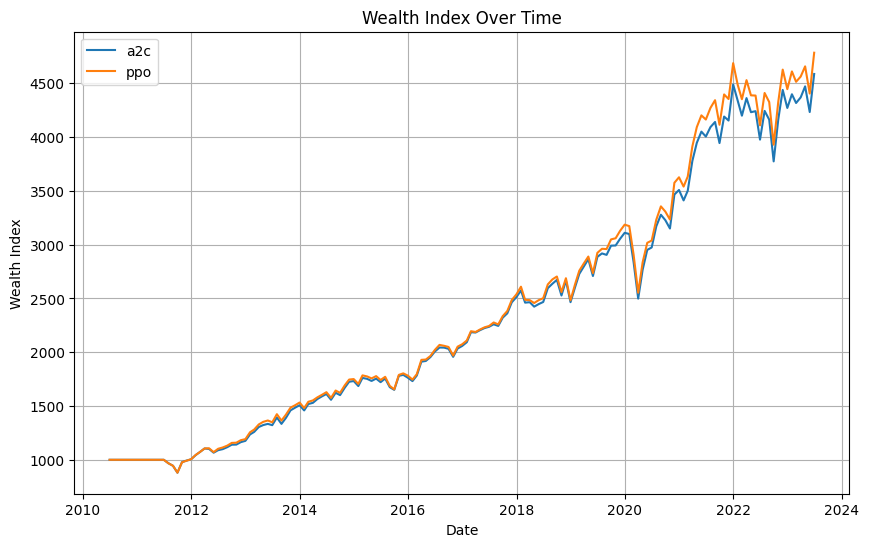

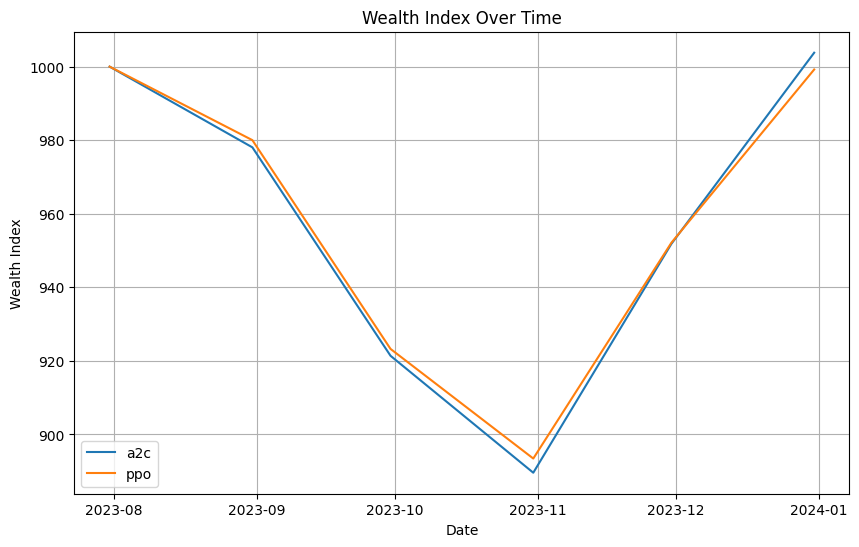

In [ ]:
train_metrics = pd.DataFrame()
train_rets = pd.DataFrame()
test_metrics = pd.DataFrame()
test_rets = pd.DataFrame()

for agent_name, values in agent_best_params.items():

    with open(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/{timestamp}/best_params.txt', 'a') as f:
        f.write(str(agent_name) + ': ' + str(values))
        f.write('\n')


    env_kwargs = {
                "hmax": 100,
                "initial_amount": initial_amount,
                "transaction_cost_pct": 0.001,
                "state_space": state_space,
                "stock_dim": stock_dimension,
                "tech_indicator_list": rl_train.columns[3:-2],
                "action_space": stock_dimension,
                "reward_scaling": 1e-4,
                "timestamp": timestamp,
                "agent_name": agent_name
        }

    e_train_gym = StockPortfolioEnv(df = rl_train, **env_kwargs)

    env_train, _ = e_train_gym.get_sb_env()

    ####### TEST IN-SAMPLE PERFORMANCE #######
    tuned_model = eval(agent_name.upper()).load(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/{timestamp}/{agent_name}/trained_{agent_name}_{idx}.pth', env=env_train)
    train_returns, train_wts = DRLAgent.DRL_prediction(model=tuned_model, environment = e_train_gym)


    ####### TEST OUT-OF-SAMPLE PERFORMANCE ########
    test_wts = pd.read_csv(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/{timestamp}/{agent_name}/{agent_name}_wts_{values[2]}.csv', index_col='Date')
    test_wts.index = pd.to_datetime(test_wts.index)

    for model_version in ['train', 'test']:
        if model_version == 'train':
            wts = train_wts
            prices = train_prices
        elif model_version == 'test':
            wts = test_wts
            prices = test_prices

        rl_metrics, rl_rets = perform_backtest(prices, wts, initial_amount, timestamp, agent_name)

        if model_version == 'train':
            train_metrics = pd.concat([train_metrics, rl_metrics], axis=1)
            train_rets = pd.concat([train_rets, rl_rets], axis=1)
        elif model_version == 'test':
            test_metrics = pd.concat([test_metrics, rl_metrics], axis=1)
            test_rets = pd.concat([test_rets, rl_rets], axis=1)


train_rets.to_csv(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/{timestamp}/train_rets.csv')
test_rets.to_csv(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/{timestamp}/test_rets.csv')
train_metrics.to_csv(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/{timestamp}/train_metrics.csv')
test_metrics.to_csv(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/{timestamp}/test_metrics.csv')

plot_wealth_index(train_rets, initial_amount, timestamp, 'train', f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/{timestamp}/')
plot_wealth_index(test_rets, initial_amount, timestamp, 'test', f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/RL/models/{timestamp}/')